# STEP 0: Decide how many samples to potentially look at

In [13]:
num_samples = 50
%matplotlib notebook
import torch
import numpy as np
import json

from tqdm import tqdm
from torch.autograd import Variable
import torchvision.transforms as transforms

import data
import config
import utils
import data

import model_batchnormDP0
import model_batchnormDP05
import model_dropout0
import model_dropout05

import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

from demo.vqaTools.vqa import VQA
import random
import os
from PIL import Image

# STEP 1: Change to the FOUR pretrained model AND the directory for your data

# Set up cell, running the cell will take a while, ONLY NEED TO RUN ONCE, just keep changing index

In [21]:

# NET ONE
log = torch.load('logs/batchnormDP0.pth')
tokens = len(log['vocab']['question']) + 1
net1 = torch.nn.DataParallel(model_batchnormDP0.Net(tokens)).cuda()
net1.load_state_dict(log['weights'])
# NET TWO
log = torch.load('logs/batchnormDP05.pth')
tokens = len(log['vocab']['question']) + 1
net2 = torch.nn.DataParallel(model_batchnormDP05.Net(tokens)).cuda()
net2.load_state_dict(log['weights'])
# NET THREE
log = torch.load('logs/dropout0.pth')
tokens = len(log['vocab']['question']) + 1
net3 = torch.nn.DataParallel(model_dropout0.Net(tokens)).cuda()
net3.load_state_dict(log['weights'])
# NET FOUR
log = torch.load('logs/dropout05.pth')
tokens = len(log['vocab']['question']) + 1
net4 = torch.nn.DataParallel(model_dropout05.Net(tokens)).cuda()
net4.load_state_dict(log['weights'])

datavqa = data.get_VQA(val=True)

dataDir     ='./data'
versionType ='v2_' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='val2014'
annFile     ='%s/%s_%s_annotations.json'%(dataDir, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
imgDir      = '%s/%s/' %(dataDir, dataSubType)
vqa=VQA(annFile, quesFile)

def collate_fn(batch):
    # put question lengths in descending order so that we can use packed sequences later
    batch.sort(key=lambda x: x[-1], reverse=True)
    return torch.utils.data.dataloader.default_collate(batch)

tens_loader = torch.utils.data.DataLoader(
        datavqa,
        batch_size=1,
        shuffle=False, 
        pin_memory=True,
        num_workers=config.data_workers,
        collate_fn=collate_fn,
    )

t = 0
# idxs = []
v_s, q_s, a_s, q_lens = [], [], [], [] 
for v, q, a, idx, q_len in tens_loader:
    var_params = {
            'volatile': False,
            'requires_grad': False,
        }
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)
    v_s.append(v)
    a_s.append(a)
    q_s.append(q)
    q_lens.append(q_len)
    t += 1
    if t == num_samples: break

def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = torch.nn.functional.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1), attention

def tens_to_img(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    return image

loading VQA annotations and questions into memory...
0:00:02.728299
creating index...
index created!


# This is all questions and answers for the image from the validation set,
# STEP 2: mess around with index to find a good question

In [ ]:
index = 70 # must be less than num_samples

coco_id = datavqa.coco_ids[index]
annIds = vqa.getQuesIds(imgIds=[coco_id])
anns = vqa.loadQA(annIds)
for randomAnn in anns:
    vqa.showQA([randomAnn])  

imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
    print(imgDir + imgFilename)
    origimg = plt.imread(imgDir + imgFilename)
    I = Image.open(imgDir + imgFilename).convert('RGB')
    origimg = I
    fig_orig = plt.figure()
    plt.imshow(I)
    plt.axis('off')
    plt.show()


# This is the question given to the network,
# STEP 3: Check if this is a good question with appropriate answers with above 

In [ ]:
# find questions that have good answers
question_ind, question_len = datavqa.questions[index]
question_ind = question_ind.numpy()
voc = datavqa.vocab['question']
rev_voc = dict((v,k) for k,v in voc.items())
for i in range(question_len):
    print(rev_voc[question_ind[i]], end=' ')

# The following are the output of the networks (2 attention and the answer)
# CHANGE THE NETS

In [ ]:
netname = ["Batch Norm, No Dropout", "Batch Norm, Dropout 50%", "No Batch Norm, No Dropout", "No Batch Norm, Dropout 50%"]
allglimpses = []

In [ ]:
for net_i, net in enumerate([net1, net2, net3, net4]):
    # pass image through network
    transform = transforms.Compose([
                transforms.Scale(config.image_size),
                transforms.CenterCrop(config.image_size),
                transforms.ToTensor(),
            ])
    
    transform2 = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5]),
            ])
    I_tens = transform(I) 
    background = tens_to_img(I_tens)
    q = q_s[index]
    v = v_s[index]
    a = a_s[index]
    q_len = q_lens[index]

    net.eval()
    hq = net.module.text(q, list(q_len.data))
    hv = v/(v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
    ha = net.module.attention(hv, hq)
    hv, attent = apply_attention(hv, ha)

    # get glimpse 1
    tens = attent[0, 0, 0, :]
    tens.shape[0]
    attent_img = tens.view(14,14).to('cpu').detach().numpy()
    up_img = ndimage.zoom(attent_img, 32, order=0)
    blur = ndimage.gaussian_filter(up_img, sigma=10)
    blur3 = 191*blur
    overlay = np.stack((blur3,blur3,blur3), axis=2)
    glimpse1 = cv2.addWeighted(background, 0.4,overlay,0.1,0)

    # get glimpse 2
    tens = attent[0, 1, 0, :]
    tens.shape[0]
    attent_img = tens.view(14,14).to('cpu').detach().numpy()
    up_img = ndimage.zoom(attent_img, 32, order=0)
    blur = ndimage.gaussian_filter(up_img, sigma=10)
    blur3 = 191*blur
    overlay = np.stack((blur3,blur3,blur3), axis=2)
    glimpse2 = cv2.addWeighted(background, 0.4,overlay,0.1,0)

    white = [255,255,255] 
    origI = tens_to_img(transform2(origimg))
    bordersz = int((origI.shape[0]-glimpse1.shape[0])/2)

    glimpse1=cv2.copyMakeBorder(glimpse1,bordersz,bordersz,5,5,cv2.BORDER_CONSTANT,value=white)
    glimpse2=cv2.copyMakeBorder(glimpse2,bordersz,bordersz,5,5,cv2.BORDER_CONSTANT,value=white)

    allglimpses.append([glimpse1, glimpse2])
        
    
    # answers 
    out = net(v, q, q_len)
    _, answer = out.data.cpu().max(dim=1)
    answ = (answer.view(-1))
    ans_voc = dict((v,k) for k,v in datavqa.answer_to_index.items())
    
    if net_i == 0:
        question = ""
        for i in range(question_len):
            print(rev_voc[question_ind[i]], end=' ')
            question = question + rev_voc[question_ind[i]] + ' '
        question = question + '?'    
        print("?")
    print("Network ({0}) answer: {1}".format(netname[net_i], ans_voc[answ.item()]))


<IPython.core.display.Javascript object>


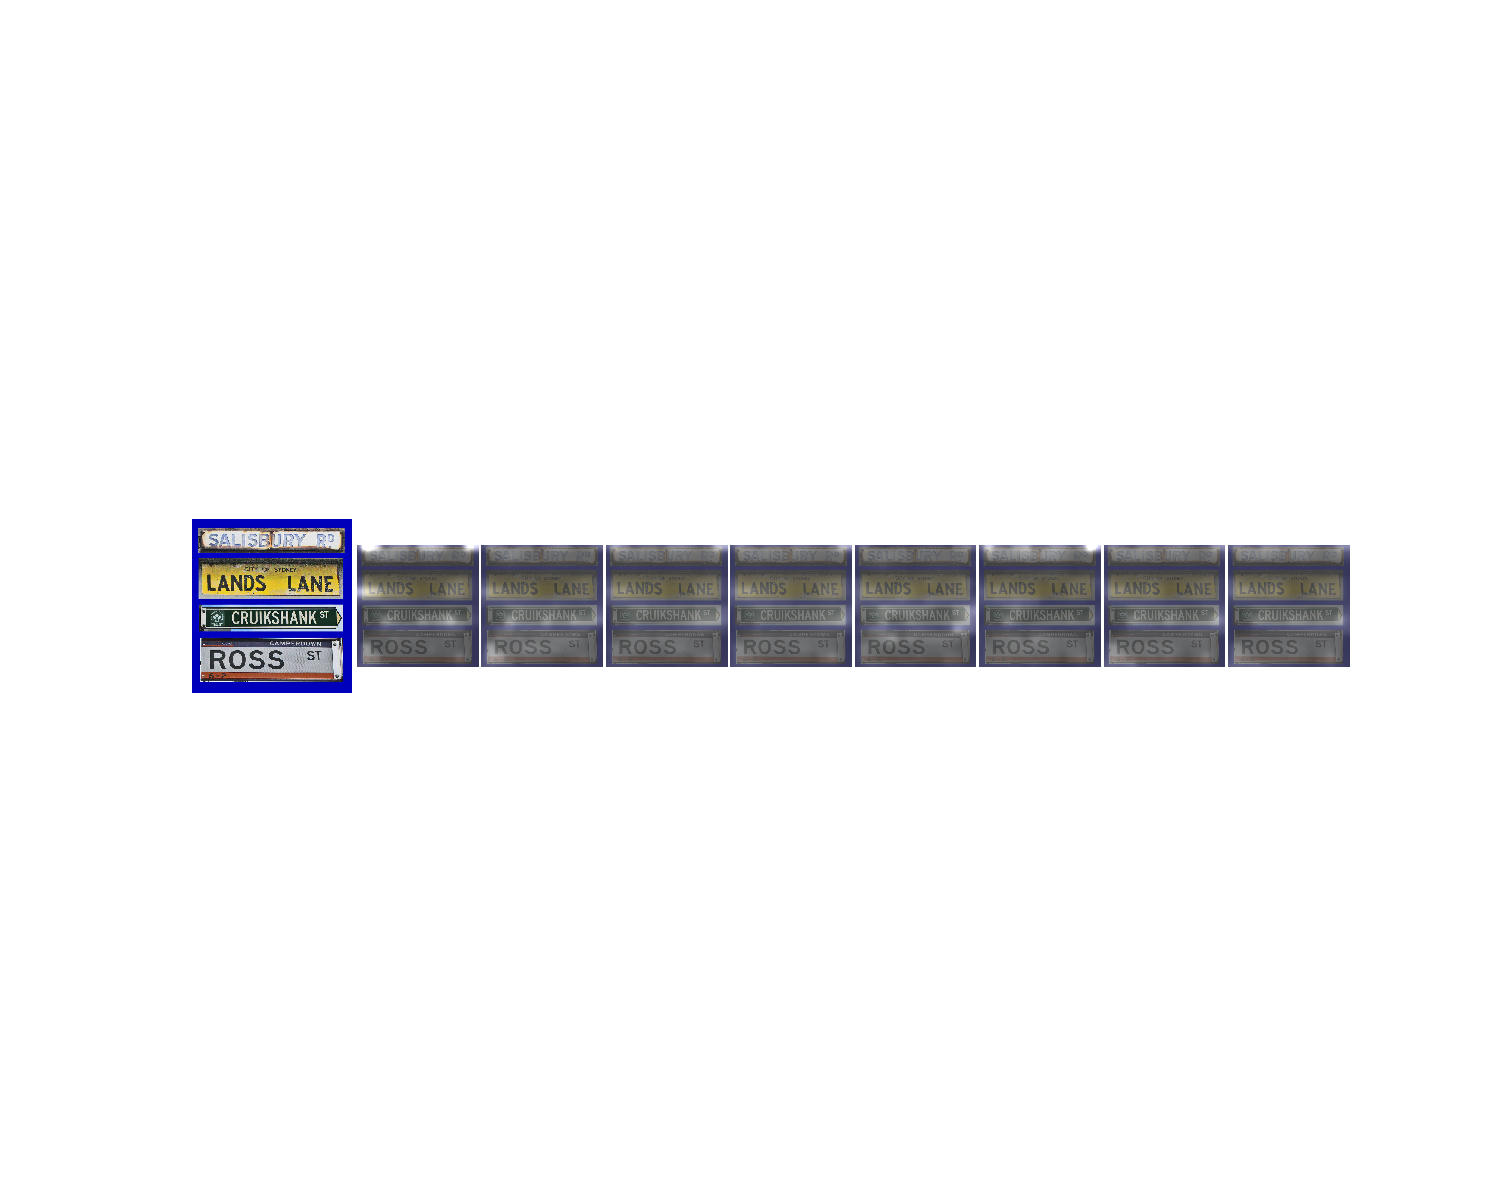

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [69]:
glimpses= np.concatenate((allglimpses[0][0], allglimpses[0][1]), axis=1)
for i in range(1,4):
    row = np.concatenate((allglimpses[i][0], allglimpses[i][1]), axis=1)
    glimpses = np.concatenate((glimpses, row), axis=1)



origimg_fitted = cv2.copyMakeBorder(origI,0,0,15,15,cv2.BORDER_CONSTANT,value=white)

glimpses = np.concatenate((origimg_fitted, glimpses), axis=1)
fig_glimpses = plt.figure(figsize=(10,8))
plt.title("Question (Index {0}): {1} ".format(index, question))
plt.axis("off")
plt.imshow(glimpses)

In [71]:
fig_glimpses.savefig("image_{0}".format(index), dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
